# Titanic
## Задача: предсказать выживших на тестовом датасете

## Данные

* PassengerId - идентификатор пассажира
* Survived - выжил или нет
* Pclass - класс пассажира (1 — высший, 2 — средний, 3 — низший)
* Name - Ф.И.О.
* Sex - пол
* Age - возраст
* SibSp - количество братьев и сестер / супругов на борту Титаника
* Parch - количество родителей / детей на борту Титаника
* Ticket - номер билета
* Fare - плата за проезд
* Cabin - номер каюты
* Embarked -  порт отправления (C = Cherbourg, Q = Queenstown, S = Southampton)

In [755]:
import pandas as pd
from pandas.plotting import scatter_matrix 
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

from sklearn.preprocessing import LabelEncoder

In [756]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer

In [757]:
train_data = pd.read_csv('Titanic_Data/train.csv')
test_data = pd.read_csv('Titanic_Data/test.csv')
answer_data = pd.read_csv('Titanic_Data/gender_submission.csv')

## 1. Обзор данных

In [758]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [759]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [760]:
answer_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Тестовые данные не содержат колонки **survived**, колонка вынесена в отдельный файл **answer_data**. Для удобства внесём её в **test_data**:

In [761]:
test_data = pd.merge(test_data, answer_data, on='PassengerId')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000042CE6438>,
      dtype=object)

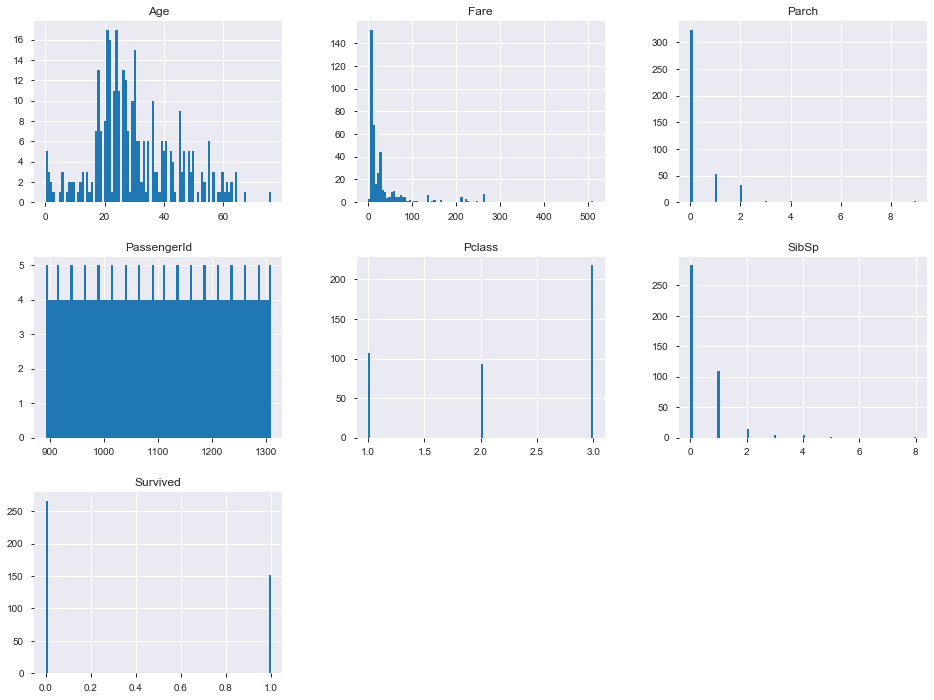

In [762]:
test_data.hist(bins=100, figsize=(16, 12))

Построим матрицу корреляции:

In [763]:
corr_matrix = train_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

* Чем выше цена билета, тем больше возможность выжить;
* Выживаемость у класса 1 больше, чем у класса 3.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000043BDE978>,
      dtype=object)

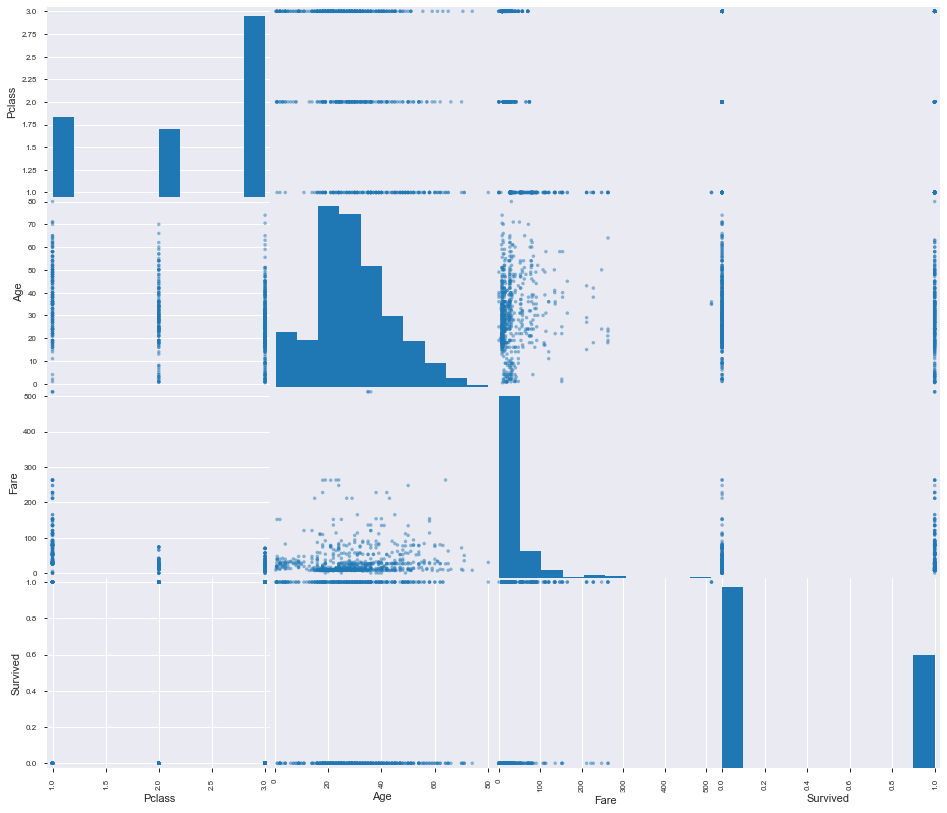

In [764]:
attributes = ['Pclass', 'Age', 'Fare', 'Survived', ]
scatter_matrix(train_data[attributes], figsize=(16, 14))

## 2. Предобработка данных

### 2.1 Обработка пропусков

Рассмотрим наличие пропусков в обучающем и тестовом наборах данных:

In [765]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [766]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


Пропуски содержатся в следующих столбцах:

* **Age**
* **Cabin**
* **Embarked**

#### 2.1.1 Пропуски в столбце Age

Если обратиться к столбцу **Name**, можно заметить, что столбец содержит данные о статусе пассажиров. Данный статус говорит о приблизительном возрасте пассажиров. Выделим статус в отдельный столбец для каждого пассажира:

In [767]:
def get_status(row):
    name = row['Name']
    if 'Mr.' in name:
        return 'Mr'
    if 'Miss.' in name:
        return 'Miss'
    if 'Mrs.' in name:
        return 'Mrs'   
    if 'Master.' in name:
        return 'Master'      
    if 'Don.' in name:
        return 'Don' 
    if 'Dr.' in name:
        return 'Dr'     
    if 'Rev.' in name:
        return 'Rev'     
    if 'Ms.' in name:
        return 'Ms' 
    if 'Major.' in name:
        return 'Major'   
    if 'Col.' in name:
        return 'Col'   

In [768]:
train_data['Status'] = train_data.apply(get_status, axis=1)
test_data['Status'] = test_data.apply(get_status, axis=1)

Небольшая часть пассажиров осталась с невыделенными статусами, но т.к. среди данных пассажиров нет людей с пропущенным возрастом, это не принципиально. Рассмотрим все статусы, что встречаются у пассажиров, у которых не указан возраст:

In [769]:
train_data.query('Age.isna()', engine='python')['Status'].value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Status, dtype: int64

In [770]:
test_data.query('Age.isna()', engine='python')['Status'].value_counts()

Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Status, dtype: int64

Рассмотрим статусы пассажиров, для которых возраст указан:

In [771]:
train_data.query('Age.notna()', engine='python')['Status'].value_counts()

Mr        398
Miss      146
Mrs       108
Master     36
Dr          6
Rev         6
Col         2
Major       2
Ms          1
Don         1
Name: Status, dtype: int64

Найдём средний возраст для каждого статуса, встречающегося среди пассажиров с пустой графой возраста, из данных с указанными возрастами:

In [772]:
avg_mr = train_data.query('Age.notna() and Status == "Mr"', engine='python')['Age'].mean()
avg_miss = train_data.query('Age.notna() and Status == "Miss"', engine='python')['Age'].mean()
avg_mrs = train_data.query('Age.notna() and Status == "Mrs"', engine='python')['Age'].mean()
avg_master = train_data.query('Age.notna() and Status == "Master"', engine='python')['Age'].mean()
avg_dr_m = train_data.query('Age.notna() and Status == "Dr" and Sex == "male"', engine='python')['Age'].mean()
avg_dr_f = train_data.query('Age.notna() and Status == "Dr" and Sex == "female"', engine='python')['Age'].mean()
avg_ms = train_data.query('Age.notna() and Status == "Ms"', engine='python')['Age'].mean()

In [773]:
print('Average age "Mr":', avg_mr)
print('Average age "Miss":', avg_miss)
print('Average age "Mrs":', avg_mrs)
print('Average age "Master":', avg_master)
print('Average age "Dr, fem":', avg_dr_m)
print('Average age "Dr, male":', avg_dr_f)
print('Average age "Ms":', avg_ms)

Average age "Mr": 32.368090452261306
Average age "Miss": 21.773972602739725
Average age "Mrs": 35.898148148148145
Average age "Master": 4.574166666666667
Average age "Dr, fem": 40.6
Average age "Dr, male": 49.0
Average age "Ms": 28.0


Полученные данные можно применить для заполнения пропусков в столбце **Age**:

In [774]:
def fill_age(data):
    data[(data['Age'].isna()) & (data['Status'] == 'Mr')] = \
        data[(data['Age'].isna()) & (data['Status'] == 'Mr')].fillna(avg_mr)
    data[(data['Age'].isna()) & (data['Status'] == 'Miss')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Miss')].fillna(avg_miss)
    data[(data['Age'].isna()) & (data['Status'] == 'Mrs')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Mrs')].fillna(avg_mrs)
    data[(data['Age'].isna()) & (data['Status'] == 'Master')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Master')].fillna(avg_master)
    
    data[(data['Age'].isna()) & (data['Status'] == 'Dr') & (data['Sex'] == 'male')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Dr') & (data['Sex'] == 'male')].fillna(avg_dr_m)
    data[(data['Age'].isna()) & (data['Status'] == 'Dr') & (data['Sex'] == 'female')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Dr') & (data['Sex'] == 'female')].fillna(avg_dr_f)    
    
    data[(data['Age'].isna()) & (data['Status'] == 'Ms')] = \
            data[(data['Age'].isna()) & (data['Status'] == 'Ms')].fillna(avg_master)
    return data

In [775]:
train_data = fill_age(train_data)
test_data = fill_age(test_data)

In [776]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          362 non-null object
Embarked       889 non-null object
Status         883 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [777]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          173 non-null object
Embarked       418 non-null object
Survived       418 non-null int64
Status         417 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 45.7+ KB


#### 2.1.2 Пропуски в столбце Cabin

Заполним на **Unknown**:

In [778]:
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')
test_data['Cabin'] = test_data['Cabin'].fillna('Unknown')

#### 2.1.3 Пропуски в столбце Embarked

In [779]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [780]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')
test_data['Embarked'] = test_data['Embarked'].fillna('S')

#### 2.1.3 Пропуски в столбце Fare

Рассмотрим пропуск в столбце **Fare**:

In [781]:
test_data.query('Fare.isna()', engine='python')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Status
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Unknown,S,0,Mr


Всего один пропуск. Цена наверняка зависит от класса. Проверим это посредством матрицы корреляции:

In [782]:
corr_matrix['Fare']

PassengerId    0.012658
Survived       0.257307
Pclass        -0.549500
Age            0.096067
SibSp          0.159651
Parch          0.216225
Fare           1.000000
Name: Fare, dtype: float64

Действительно, стоимость билета обратно пропорциональна классу. Рассчитаем средние стоимости для каждого класса:

In [783]:
print('Средняя стоимость билета 3 класса:', train_data.query('Pclass == 3')['Fare'].mean())
print('Средняя стоимость билета 2 класса:', train_data.query('Pclass == 2')['Fare'].mean())
print('Средняя стоимость билета 1 класса:', train_data.query('Pclass == 1')['Fare'].mean())

Средняя стоимость билета 3 класса: 13.675550101832997
Средняя стоимость билета 2 класса: 20.66218315217391
Средняя стоимость билета 1 класса: 84.15468749999992


Поскольку пассажир с пропущенной стоимостью является пассажиром 3 класса, заполним пропуск значением средней цены для 3 класса:

In [784]:
test_data['Fare'] = test_data['Fare'].fillna(train_data.query('Pclass == 3')['Fare'].mean())

### 2.2 Подготовка признаков

Рассмотрим признаки, их вероятное влияние на целевой признак и выберем методы обработки:

| Наименование признака | Расшифровка признака | Тип признака | Влияние на целевой признак | Необходимые преобразования |
|----------------------|--|---------|--------------------|--------------------------------------------|
|   **PassengerId**   | идентификатор пассажира | **категориальный**| отсутствует | исключить из расчётов |
|   **Pclass**     | класс пассажира | **категориальный** |присутствует | провести кодирование |
|   **Name** | Ф.И.О. |**категориальный**|  отсутствует| исключить из расчётов |
|   **Sex**   | пол | **категориальный**  |присутствует| провести кодирование |
|   **Age**   | возраст |количественный|  присутствует| провести масштабирование |
|   **SibSp**   | количество братьев и сестер / супругов на борту Титаника |количественный|  присутствует|  совместить с **Parch** |
|   **Parch**   | количество родителей / детей на борту Титаника | количественный|  присутствует| совместить с **SibSp**|
|   **Ticket**   | номер билета |**категориальный**|  отсутствует| исключить из расчётов |
|   **Fare**   | плата за проезд |количественный|  присутствует|  провести масштабирование|
|   **Cabin**   | номер каюты | **категориальный**| отсутствует| исключить из расчётов |
|   **Embarked**   | порт отправления |**категориальный**| присутствует| провести кодирование |
|   **Survived** (*целевой*)  | выжил или нет |**категориальный** |-  |- |

#### 2.2.1 Кодирование категориальных признаков

#### 2.2.1.1 Кодирование SibSp и Parch

Выделим категорию **isAlone** - пассажир на корабле без семьи и родственников. В качестве вторичного признака посчитаем число родственников для каждого пассажира (**numRelatives**):

In [785]:
train_data['isAlone'] = np.where((train_data['Parch'] + train_data['SibSp']) == 0, 1, 0)
test_data['isAlone'] = np.where((test_data['Parch'] + test_data['SibSp']) == 0, 1, 0)

train_data['numRelatives'] = train_data['Parch'] + train_data['SibSp']
test_data['numRelatives'] = test_data['Parch'] + test_data['SibSp']

#### 2.2.1.2 Кодирование Sex

Столбец **Sex** требует приведения к числовому виду. Рассмотрим число уникальных значений и убедимся, что их всего 2:

In [786]:
train_data['Sex'].unique()

array(['male', 'female'], dtype=object)

Проведём кодирование:

In [787]:
train_data['Sex'] = LabelEncoder().fit_transform(train_data['Sex'])
test_data['Sex'] = LabelEncoder().fit_transform(test_data['Sex'])

#### 2.2.1.3 Кодирование Embarked

In [788]:
train_data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [789]:
coded_embarked = pd.get_dummies(train_data['Embarked'])
train_data = pd.concat([train_data, coded_embarked], axis=1)
train_data = train_data.drop(['Embarked'], axis=1)

coded_embarked = pd.get_dummies(test_data['Embarked'])
test_data = pd.concat([test_data, coded_embarked], axis=1)
test_data = test_data.drop(['Embarked'], axis=1)

#### 2.2.1.4 Кодирование Cabin

In [790]:
train_data['isKnownCabin'] = np.where((train_data['Cabin'] != 'Unknown'), 1, 0)
test_data['isKnownCabin'] = np.where((test_data['Cabin'] != 'Unknown'), 1, 0)

#### 2.2.2 Масштабирование количественных признаков

In [791]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

In [792]:
#train_data[['Fare', 'Age']] = minmax_scale.fit_transform(train_data[['Fare', 'Age']])
#test_data[['Fare', 'Age']] = minmax_scale.fit_transform(test_data[['Fare', 'Age']])

#### 2.2.3 Создание новых признаков

Попробуем извлечь из параметра **Age** дополнительные признаки. Рассмотрим распределение выживших по возрастам: 

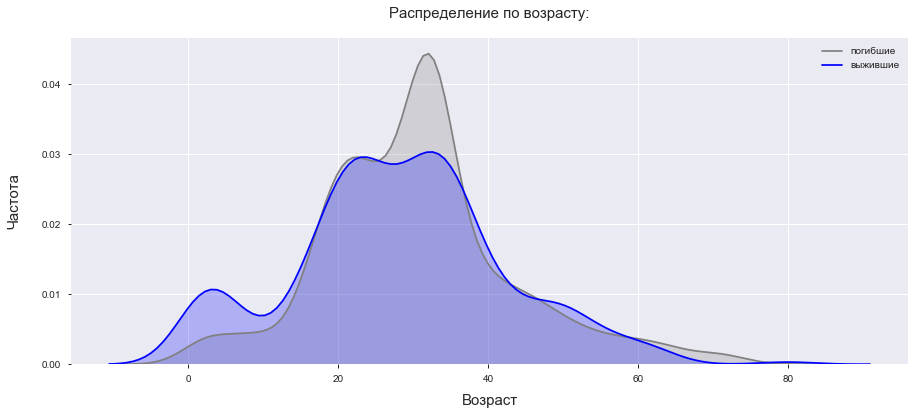

In [793]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(train_data.loc[(train_data['Survived'] == 0),'Age'] , color='gray',shade=True,label='погибшие')
ax=sns.kdeplot(train_data.loc[(train_data['Survived'] == 1),'Age'] , color='b',shade=True, label='выжившие')
plt.title('Распределение по возрасту:', fontsize = 15, pad = 20)
plt.xlabel("Возраст", fontsize = 15, labelpad = 10)
plt.ylabel('Частота', fontsize = 15, labelpad= 20);

Согласно графику, можно сделать следующие выводы:
* количество выживших существенно больше среди детей
* большое число погибших среди пассажиров возраста 25-38 лет
* люди в возрасте за 60 выживали реже

Разделим параметр **Age** по категориям:

In [794]:
categories = [12, 50]

In [795]:
train_data['AgeGr'] = np.digitize(train_data['Age'], bins=categories)
test_data['AgeGr'] = np.digitize(test_data['Age'], bins=categories)

In [796]:
train_data['AgeGr'].unique()

array([1, 2, 0], dtype=int64)

In [797]:
train_data['AgeGr'] = train_data['AgeGr'].replace(0, 'Child').replace(1, 'Adult').replace(2, 'Old')
test_data['AgeGr'] = test_data['AgeGr'].replace(0, 'Child').replace(1, 'Adult').replace(2, 'Old')

In [798]:
coded_age = pd.get_dummies(train_data['AgeGr'])
train_data = pd.concat([train_data, coded_age], axis=1)
train_data = train_data.drop(['AgeGr'], axis=1)

coded_age = pd.get_dummies(test_data['AgeGr'])
test_data = pd.concat([test_data, coded_age], axis=1)
test_data = test_data.drop(['AgeGr'], axis=1)

## 3. Предпросмотр готовых данных

In [800]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Status,isAlone,numRelatives,C,Q,S,isKnownCabin,Adult,Child,Old
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,Mr,0,1,0,0,1,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,Mrs,0,1,1,0,0,1,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,1,0,0,0,1,0,1,0,0


In [801]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null int32
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           891 non-null object
Status          883 non-null object
isAlone         891 non-null int32
numRelatives    891 non-null int64
C               891 non-null uint8
Q               891 non-null uint8
S               891 non-null uint8
isKnownCabin    891 non-null int32
Adult           891 non-null uint8
Child           891 non-null uint8
Old             891 non-null uint8
dtypes: float64(2), int32(3), int64(6), object(4), uint8(6)
memory usage: 99.3+ KB


In [802]:
corr_matrix = train_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived        1.000000
Fare            0.257307
isKnownCabin    0.178796
C               0.168240
Child           0.113161
Parch           0.081629
numRelatives    0.016639
Q               0.003650
PassengerId    -0.005007
Old            -0.011742
SibSp          -0.035322
Adult          -0.074566
Age            -0.089051
S              -0.149683
isAlone        -0.203367
Pclass         -0.338481
Sex            -0.543351
Name: Survived, dtype: float64

## 4. Выделение признаков и обучение модели

Выделим факторы влияния и целевой признак для тестового и обучающего набора:

In [803]:
features = ['Pclass', 'Sex', 'isAlone', 'C', 'Q', 'S', 'Fare', 'isKnownCabin', 'numRelatives', 'Child', 'Adult', 'Old']

target = ['Survived']

In [804]:
features_train = train_data[features]
target_train = train_data[target]

features_test = test_data[features]
target_test = test_data[target]

### 4.1 Decision Tree

In [805]:
grid_param = {
    'max_depth': [i for i in range(1, 20)],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
    'min_samples_split': [i for i in range(2, 8)]
    
}

In [806]:
classifier = DecisionTreeClassifier(random_state=42)

In [807]:
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [808]:
gd_sr.fit(features_train, target_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2}


In [809]:
dt_clf = DecisionTreeClassifier(random_state=42, max_depth = 6, criterion='entropy', min_samples_split=2)
dt_clf.fit(features_train, target_train)
train_predictions = dt_clf.predict(features_train)
test_predictions = dt_clf.predict(features_test)
train_accuracy = accuracy_score(target_train, train_predictions)
test_accuracy = accuracy_score(target_test, test_predictions)

print("Accuracy")
print("Обучающая выборка:", train_accuracy)
print("Тестовая выборка: ", test_accuracy)

Accuracy
Обучающая выборка: 0.8641975308641975
Тестовая выборка:  0.9019138755980861


In [810]:
scores = cross_val_score(dt_clf, features_train, target_train, scoring='roc_auc', cv=10)
print('ROC-AUC: ', f"{scores.mean()} ± {scores.std()}")
scores = cross_val_score(dt_clf, features_train, target_train, scoring='accuracy', cv=10)
print('Accuracy:', f"{scores.mean()} ± {scores.std()}")

ROC-AUC:  0.870178564355035 ± 0.04256751344760446
Accuracy: 0.8373377028714106 ± 0.042704768960955444


## 5. Запись результатов

Предсказанный результат запишем в столбец **Survived**:

In [811]:
test_data['Survived'] = test_predictions

Запишем результаты в **csv**:

In [812]:
test_data.index = test_data['PassengerId']

In [813]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Status,isAlone,numRelatives,C,Q,S,isKnownCabin,Adult,Child,Old
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,Unknown,...,Mr,1,0,0,1,0,0,1,0,0
893,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,Unknown,...,Mrs,0,1,0,0,1,0,1,0,0
894,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,Unknown,...,Mr,1,0,0,1,0,0,0,0,1


In [814]:
pd.DataFrame(test_data[:], columns=['Survived']).to_csv('results.csv')

## Вывод

Наилучший результат достигнут **DecisionTreeClassifier** с параметрами:

['Pclass', 'Sex', 'isAlone', 'C', 'Q', 'S', 'Fare', 'isKnownCabin', 'numRelatives', 'Child', 'Adult', 'Old']

DecisionTreeClassifier(random_state=42, max_depth = 6, criterion='entropy', min_samples_split=2)

Обучающая выборка: 0.9090909090909091

Тестовая выборка:  0.861244019138756

**0.80861**

ROC-AUC:  0.838638075432193 ± 0.052210990478612475

Accuracy: 0.832942912268755 ± 0.051761551220246456